# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
import training
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [2]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'PMLC',
                        'data_processed', 'Dataset_Pendigits.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
M, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, M, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [3]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(6.1658))

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
test_rate = 0.2
M_train = int(M*train_rate)
M_test = int(M*test_rate)
train_data, rest_data = random_split(dataset, [M_train, M-M_train])
test_data, valid_data = random_split(rest_data, [M_test, M-M_train-M_test])
len(train_data), len(test_data), len(valid_data)

(6595, 2198, 2199)

In [5]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Definite PNN and AgingAwarePNN

In [31]:
N_Hidden = 15
AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                                pnn.PNNLayer(N_Hidden, N_Hidden,
                                             age_generator),
                                pnn.PNNLayer(N_Hidden, N_Hidden,
                                             age_generator),
                                pnn.PNNLayer(N_Hidden, N_class, age_generator))
K = 5  # number of time sampling
M = 20  # number of model sampling
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001 / M / K)
AAPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [7]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
PNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
  (3): PNNLayer()
)

In [8]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class))

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.005)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=16, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): Tanh()
  (4): Linear(in_features=15, out_features=15, bias=True)
  (5): Tanh()
  (6): Linear(in_features=15, out_features=10, bias=True)
)

# Normal NN

In [10]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(200)):
    for x_train, y_train in train_loader:
        optimizer_NN.zero_grad()
        prediction = NN(x_train)
        loss = celoss(prediction, y_train)
        loss.backward()
        optimizer_NN.step()

    for x_test, y_test in test_loader:
        prediction_test = NN(x_test)
        y_hat = torch.argmax(prediction_test, 1).data.numpy().squeeze()
        acc_test = sum(y_hat == y_test.numpy()) / y_test.shape[0]
        loss_test = celoss(prediction_test, y_test)
    if epoch % 10 == 0:
        print(f'| Epoch: {epoch:-5d} | Accuracy: {acc_test:.5f} | Loss: {loss_test.data:.5f} |')

  0%|          | 0/200 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.24932 | Loss: 2.26049 |
| Epoch:    10 | Accuracy: 0.47816 | Loss: 1.96212 |
| Epoch:    20 | Accuracy: 0.54186 | Loss: 1.61803 |
| Epoch:    30 | Accuracy: 0.71019 | Loss: 1.32719 |
| Epoch:    40 | Accuracy: 0.75250 | Loss: 1.07422 |
| Epoch:    50 | Accuracy: 0.76843 | Loss: 0.86840 |
| Epoch:    60 | Accuracy: 0.79117 | Loss: 0.71625 |
| Epoch:    70 | Accuracy: 0.82348 | Loss: 0.58925 |
| Epoch:    80 | Accuracy: 0.88535 | Loss: 0.48065 |
| Epoch:    90 | Accuracy: 0.90673 | Loss: 0.39779 |
| Epoch:   100 | Accuracy: 0.92175 | Loss: 0.33663 |
| Epoch:   110 | Accuracy: 0.92721 | Loss: 0.28897 |
| Epoch:   120 | Accuracy: 0.93631 | Loss: 0.24973 |
| Epoch:   130 | Accuracy: 0.94404 | Loss: 0.21805 |
| Epoch:   140 | Accuracy: 0.95086 | Loss: 0.19289 |
| Epoch:   150 | Accuracy: 0.95632 | Loss: 0.17182 |
| Epoch:   160 | Accuracy: 0.95996 | Loss: 0.15397 |
| Epoch:   170 | Accuracy: 0.96451 | Loss: 0.13869 |
| Epoch:   180 | Accuracy: 0.96906 | Loss: 0.1

# Normal PNN

## Train

In [27]:
m = 0.3
T = 0.1
train_loss_PNN, test_loss_PNN, parameter_PNN = training.train_normal_pnn(PNN,
                                                                         train_loader, test_loader,
                                                                         m, T, optimizer_PNN, pnn.LossFunction,
                                                                         Epoch=500)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.94404 | Loss: 0.11766 |
| Epoch:    10 | Accuracy: 0.94449 | Loss: 0.11445 |
| Epoch:    20 | Accuracy: 0.94859 | Loss: 0.11107 |
| Epoch:    30 | Accuracy: 0.94950 | Loss: 0.10834 |
| Epoch:    40 | Accuracy: 0.95132 | Loss: 0.10497 |
| Epoch:    50 | Accuracy: 0.95177 | Loss: 0.10085 |
| Epoch:    60 | Accuracy: 0.95405 | Loss: 0.09772 |
| Epoch:    70 | Accuracy: 0.95496 | Loss: 0.09447 |
| Epoch:    80 | Accuracy: 0.95541 | Loss: 0.09261 |
| Epoch:    90 | Accuracy: 0.95632 | Loss: 0.09061 |
| Epoch:   100 | Accuracy: 0.95769 | Loss: 0.08995 |
| Epoch:   110 | Accuracy: 0.95678 | Loss: 0.08827 |
| Epoch:   120 | Accuracy: 0.95723 | Loss: 0.08678 |
| Epoch:   130 | Accuracy: 0.95723 | Loss: 0.08498 |
| Epoch:   140 | Accuracy: 0.95723 | Loss: 0.08348 |
| Epoch:   150 | Accuracy: 0.95769 | Loss: 0.08262 |
| Epoch:   160 | Accuracy: 0.95860 | Loss: 0.08138 |
| Epoch:   170 | Accuracy: 0.95860 | Loss: 0.08062 |
| Epoch:   180 | Accuracy: 0.95951 | Loss: 0.0

## Early Stop

tensor(0.0692, dtype=torch.float64)

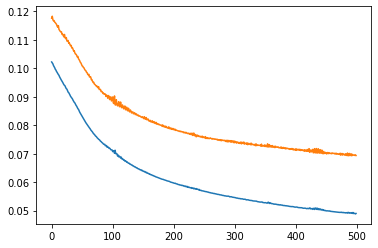

In [28]:
plt.plot(train_loss_PNN, label='train')
plt.plot(test_loss_PNN, label='test')

PNN.load_state_dict(parameter_PNN)

for x_valid, y_valid in valid_loader:
    prediction_valid = PNN(x_valid)
    loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)
loss_valid.data

# Aging Aware PNN with Model Variation

## Train

In [ ]:
importlib.reload(training)

m = 0.3
T = 0.1
test_loss_AAPNN, parameter_AAPNN = training.train_aged_pnn(AAPNN,
                                                           train_loader, test_loader,
                                                           m, T, M, K, optimizer_AAPNN,
                                                           pnn.LossFunction, Epoch=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.11101 | Loss: 1.395999429 |
| Epoch:     1 | Accuracy: 0.11101 | Loss: 1.395998412 |
| Epoch:     2 | Accuracy: 0.11101 | Loss: 1.395998732 |
| Epoch:     3 | Accuracy: 0.11101 | Loss: 1.395997389 |
| Epoch:     4 | Accuracy: 0.11101 | Loss: 1.395999352 |
| Epoch:     5 | Accuracy: 0.10747 | Loss: 1.395997939 |


## Early Stop

In [ ]:
plt.plot(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)

# Save and Read

In [ ]:
# torch.save(MyPNN, f'./simpleclassification/MyPNN_{N_Layer}_{N_Hidden}.pkl')
# torch.save(MyAgedPNN, f'./simpleclassification/MyAgedPNN_{N_Layer}_{N_Hidden}.pkl')

In [ ]:
# MyPNN = torch.load('/simpleclassification/MyPNN.pkl')
# MyAgedPNN = torch.load('/simpleclassification/MyAgedPNN.pkl')

# Evaluation
Evaluate two NNs with 1000 different aging models and over time.

## Test

In [ ]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0, 1, 100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for omega in range(1000):
    AAPNN.apply(ps.makemodel)
    PNN.apply(ps.makemodel)
    for test_t in test_time:
        AAPNN.apply(lambda z: ps.settime(z, test_t))
        PNN.apply(lambda z: ps.settime(z, test_t))

        my_aged_acc.append(evaluation.basic(AAPNN, x_valid, y_valid))
        my_acc.append(evaluation.basic(PNN, x_valid, y_valid))

        my_aged_maa.append(evaluation.maa(MyAgedPNN, x_valid, y_valid))
        my_maa.append(evaluation.maa(MyPNN, x_valid, y_valid))
    if omega % 10 == 0:
        print(f'evaluating on the {omega}-th model.')

In [ ]:
my_acc = np.array(my_acc).reshape([1000, 100])
my_aged_acc = np.array(my_aged_acc).reshape([1000, 100])

mean_acc = np.mean(my_acc, axis=0).flatten()
mean_aged_acc = np.mean(my_aged_acc, axis=0).flatten()

std_acc = np.std(my_acc, axis=0).flatten()
std_aged_acc = np.std(my_aged_acc, axis=0).flatten()

## Visualization

In [ ]:
plt.fill_between(test_time, mean_aged_acc-std_aged_acc,
                 mean_aged_acc+std_aged_acc, alpha=0.3, color='red')
plt.fill_between(test_time, mean_acc-std_acc, mean_acc +
                 std_acc, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_acc, label='aging aware', color='red')
plt.plot(test_time, mean_acc, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('basic accuracy')
plt.xlim([0, 1])
plt.legend()

In [ ]:
my_maa = np.array(my_maa).reshape([1000, 100])
my_aged_maa = np.array(my_aged_maa).reshape([1000, 100])

mean_maa = np.mean(my_maa, axis=0).flatten()
mean_aged_maa = np.mean(my_aged_maa, axis=0).flatten()

std_maa = np.std(my_maa, axis=0).flatten()
std_aged_maa = np.std(my_aged_maa, axis=0).flatten()

In [ ]:
plt.fill_between(test_time, mean_aged_maa-std_aged_maa,
                 mean_aged_maa+std_aged_maa, alpha=0.3, color='red')
plt.fill_between(test_time, mean_maa-std_maa, mean_acc +
                 std_maa, alpha=0.3, color='blue')
plt.plot(test_time, mean_aged_maa, label='aging aware', color='red')
plt.plot(test_time, mean_maa, label='previous', color='blue')
plt.xlabel('normalized time')
plt.ylabel('measure aware accuracy')
plt.xlim([0, 1])
plt.legend()